## Entertainment Software Rating Board (ESRB)

     1.The Entertainment Software Rating Board (ESRB) is an American self-regulatory organization that assigns age & content ratings to consumer video games.
     2.The board assigns ratings to games based on their content, using judgment similar to the motion picture rating systems used in many countries, using a combination of six age-based levels intended to aid consumers in determining a game's content and suitability, along with a system of "content descriptors" which detail specific types of content present in a particular game.
    3.Below ratings are used as per content:
    
    RP   : This symbol is used in promotional materials for games which have not yet been assigned a final rating by ESRB.
    E    : Generally suitable for all ages.
    E10+ : Generally suitable for those aged 10 years and older.
    M    : Generally suitable for those aged 17 years and older.
    T    : Generally suitable for those aged 13 years and older.
    K-A  : This rating was known as Kids to Adults (K-A) until 1998, when it was renamed "Everyone".
    

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score

import time
from sklearn.model_selection import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
import matplotlib.pyplot as plt
%matplotlib inline
import re
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

pd.set_option('display.max_rows',None)

In [2]:
df_train= pd.read_csv("VG_Train.csv")
print(df_train.shape)

df_test= pd.read_csv("VG_Test.csv")
print(df_test.shape)

(3506, 9)
(1503, 8)


In [3]:
df_train.columns

Index(['ID', 'CONSOLE', 'YEAR', 'CATEGORY', 'PUBLISHER', 'RATING',
       'CRITICS_POINTS', 'USER_POINTS', 'SalesInMillions'],
      dtype='object')

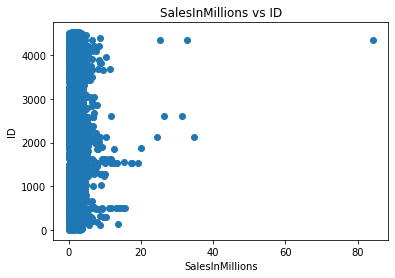

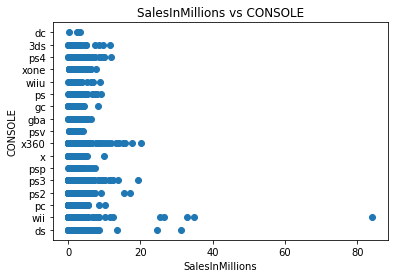

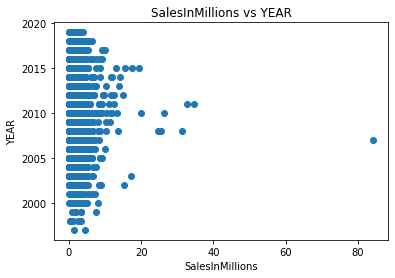

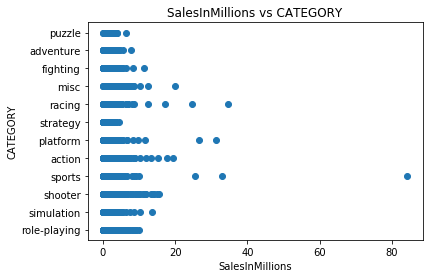

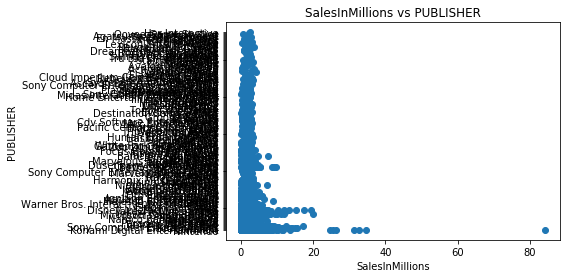

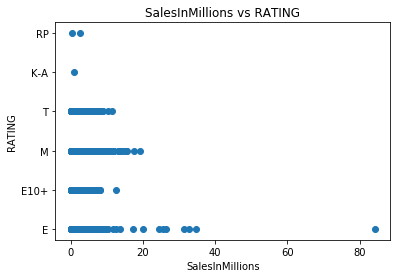

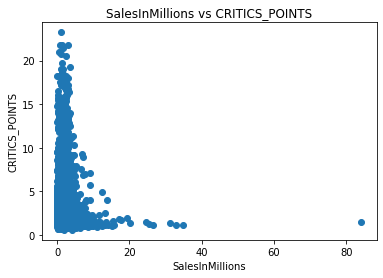

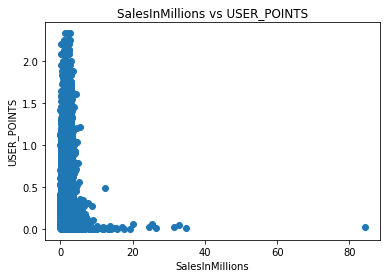

In [4]:
x_col = "SalesInMillions"
y_columns = ['ID', 'CONSOLE', 'YEAR', 'CATEGORY', 'PUBLISHER', 'RATING',
       'CRITICS_POINTS', 'USER_POINTS']


for y_col in y_columns:

    figure = plt.figure
    ax = plt.gca()
    ax.scatter(df_train[x_col], df_train[y_col])
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title("{} vs {}".format(x_col, y_col))

    plt.show()

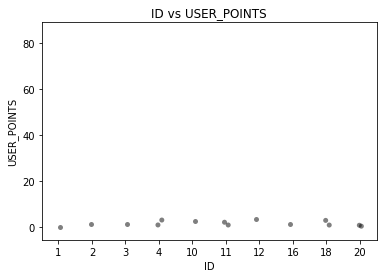

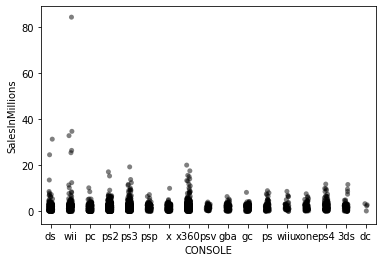

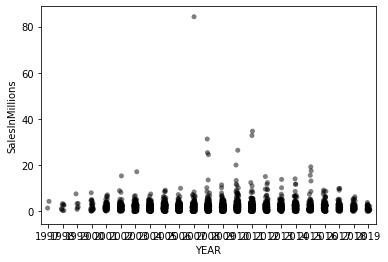

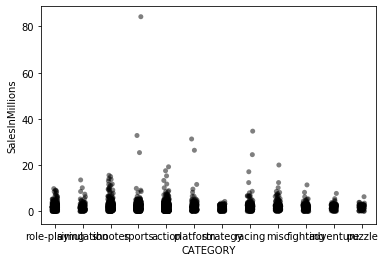

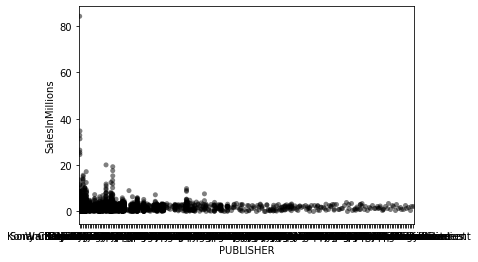

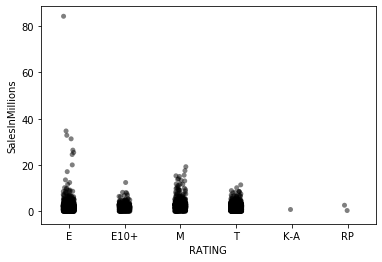

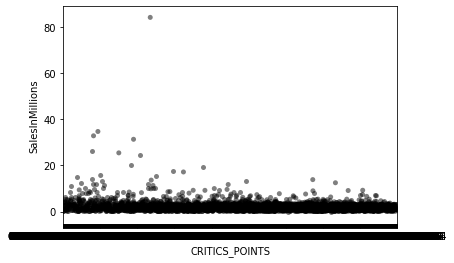

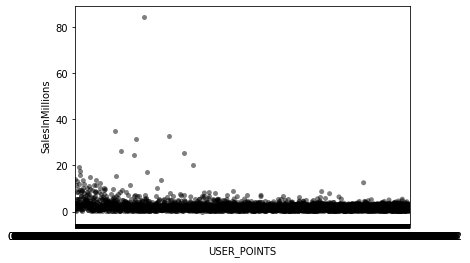

In [5]:
import seaborn as sns

x_col = "SalesInMillions"
y_columns = ['ID', 'CONSOLE', 'YEAR', 'CATEGORY', 'PUBLISHER', 'RATING',
       'CRITICS_POINTS', 'USER_POINTS']

figure = plt.figure
ax = plt.subplot(111) 

for i in y_columns:

    sns.stripplot(y= x_col, x= i, data=df_train, jitter=True,marker='o', alpha=0.5,color='black')
    ax.set_xlabel(i)
    ax.set_ylabel(y_col)
    ax.set_title("{} vs {}".format(i, y_col))
    ax.set_xlim(-0.5, 9.5)

    
    
    
    plt.show()

Index(['CONSOLE', 'CATEGORY', 'PUBLISHER', 'RATING'], dtype='object')


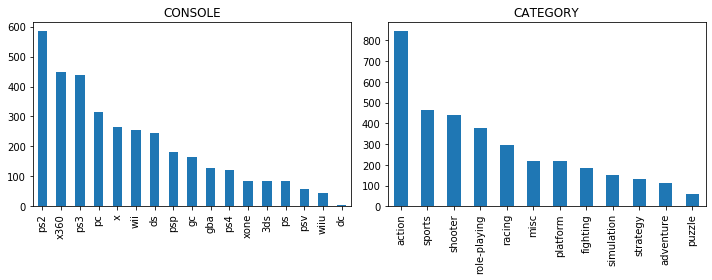

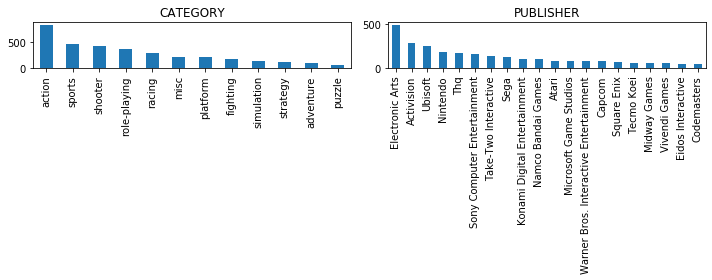

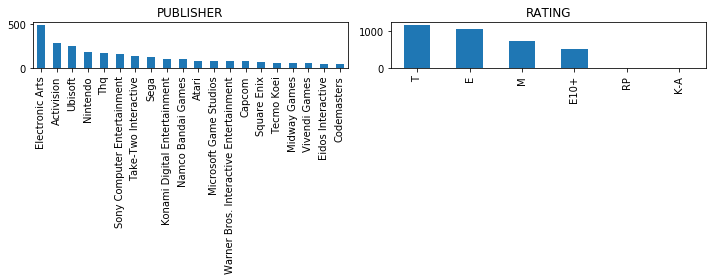

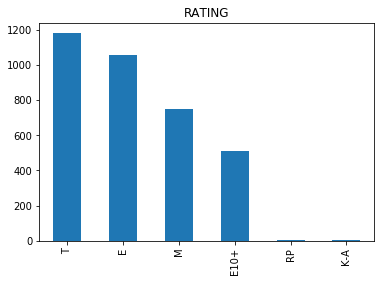

In [6]:
# Function to perform univariate analysis of categorical columns
def plot_categorical_columns(dataframe):
    categorical_columns = dataframe.select_dtypes(include=['object']).columns
    print(categorical_columns)
    
    for i in range(0,len(categorical_columns)):
            if len(categorical_columns) > i+1:
                
                plt.figure(figsize=(10,4))
                plt.subplot(121)
                dataframe[categorical_columns[i]].value_counts()[:20].plot(kind='bar')
                plt.title(categorical_columns[i])
                plt.subplot(122)     
                dataframe[categorical_columns[i+1]].value_counts()[:20].plot(kind='bar')
                plt.title(categorical_columns[i+1])
                plt.tight_layout()
                plt.show()

            else:
                dataframe[categorical_columns[i]].value_counts()[:20].plot(kind='bar')
                plt.title(categorical_columns[i])
        

plot = plot_categorical_columns(df_train)               

#### Link to the kernel :- https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study

In [7]:
def mean_encode(train_data, test_data, columns, target_col, reg_method=None,
                alpha=5, add_random=False, rmean=0, rstd=0.1, folds=1):
    '''Returns a DataFrame with encoded columns'''
    encoded_cols = []
    target_mean_global = train_data[target_col].mean()
    for col in columns:
        # Getting means for test data
        nrows_cat = train_data.groupby(col)[target_col].count()
        target_means_cats = train_data.groupby(col)[target_col].mean()
        target_means_cats_adj = (target_means_cats*nrows_cat + 
                                 target_mean_global*alpha)/(nrows_cat+alpha)
        # Mapping means to test data
        encoded_col_test = test_data[col].map(target_means_cats_adj)
        # Getting a train encodings
        if reg_method == 'expanding_mean':
            train_data_shuffled = train_data.sample(frac=1, random_state=1)
            cumsum = train_data_shuffled.groupby(col)[target_col].cumsum() - train_data_shuffled[target_col]
            cumcnt = train_data_shuffled.groupby(col).cumcount()
            encoded_col_train = cumsum/(cumcnt)
            encoded_col_train.fillna(target_mean_global, inplace=True)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))
        elif (reg_method == 'k_fold') and (folds > 1):
            kfold = KFold( n_splits = 10, shuffle = False)
            parts = []
            for tr_in, val_ind in kfold.split(train_data):
                # divide data
                df_for_estimation, df_estimated = train_data.iloc[tr_in], train_data.iloc[val_ind]
                # getting means on data for estimation (all folds except estimated)
                nrows_cat = df_for_estimation.groupby(col)[target_col].count()
                target_means_cats = df_for_estimation.groupby(col)[target_col].mean()
                target_means_cats_adj = (target_means_cats*nrows_cat + 
                                         target_mean_global*alpha)/(nrows_cat+alpha)
                # Mapping means to estimated fold
                encoded_col_train_part = df_estimated[col].map(target_means_cats_adj)
                if add_random:
                    encoded_col_train_part = encoded_col_train_part + normal(loc=rmean, scale=rstd, 
                                                                             size=(encoded_col_train_part.shape[0]))
                # Saving estimated encodings for a fold
                parts.append(encoded_col_train_part)
            encoded_col_train = pd.concat(parts, axis=0)
            encoded_col_train.fillna(target_mean_global, inplace=True)
        else:
            encoded_col_train = train_data[col].map(target_means_cats_adj)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))

        # Saving the column with means
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = target_mean_global
        encoded_cols.append(pd.DataFrame({'mean_'+target_col+'_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return all_encoded

In [8]:
cols = y_columns
target = x_col
finaldf = mean_encode(df_train,df_test,cols,target,reg_method='k_fold',folds=5)

In [9]:
print(finaldf.shape)
finaldf.head()

(5009, 8)


,mean_SalesInMillions_ID,mean_SalesInMillions_CONSOLE,mean_SalesInMillions_YEAR,mean_SalesInMillions_CATEGORY,mean_SalesInMillions_PUBLISHER,mean_SalesInMillions_RATING,mean_SalesInMillions_CRITICS_POINTS,mean_SalesInMillions_USER_POINTS
0,2.171021,2.185797,2.270856,2.111201,4.286389,2.437184,2.401005,2.111513
1,2.171021,2.941243,2.165342,2.103497,1.781607,1.878356,2.049944,1.910734
2,2.615032,1.769688,1.671641,2.491630,2.388049,2.484016,2.262033,2.171021
3,2.171021,2.185907,2.285194,2.352478,2.331842,2.437184,2.002680,2.052188
4,2.171021,2.280501,2.140816,2.080454,2.388049,2.484016,2.030408,2.171021


In [10]:
train_encoded = finaldf.iloc[0:3506,:]
print(train_encoded.shape)

test_encoded = finaldf.iloc[3506:,:]
print(test_encoded.shape)

(3506, 8)
(1503, 8)


In [11]:
X = train_encoded.copy()
y = df_train['SalesInMillions']
Xt = test_encoded.copy()

In [12]:
features = [c for c in X.columns]
print(features)

['mean_SalesInMillions_ID', 'mean_SalesInMillions_CONSOLE', 'mean_SalesInMillions_YEAR', 'mean_SalesInMillions_CATEGORY', 'mean_SalesInMillions_PUBLISHER', 'mean_SalesInMillions_RATING', 'mean_SalesInMillions_CRITICS_POINTS', 'mean_SalesInMillions_USER_POINTS']


In [13]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

In [16]:
training_start_time = time.time()
rmsle = list()
max_iter = 10
folds = StratifiedKFold(n_splits = max_iter)
oofs_xgb = np.zeros(len(X))
xgb_preds = np.zeros(len(Xt))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, pd.qcut(y, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    X_trn, y_trn = X.iloc[trn_idx][features], y.iloc[trn_idx]
    X_val, y_val = X.iloc[val_idx][features], y.iloc[val_idx]
    X_test = Xt[features]
    
    xgb = XGBRegressor(n_estimators=1000, max_depth=12, learning_rate=0.05, colsample_bytree=0.45)
    _ = xgb.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], verbose=100, early_stopping_rounds=100, eval_metric='rmse')
    
    oofs_xgb[val_idx] = xgb.predict(X_val)
    current_test_pred1 = xgb.predict(X_test)
    xgb_preds += xgb.predict(X_test)/max_iter
    
    print(f'\n Fold {rmse(np.log(y_val), np.log(oofs_xgb[val_idx]))}')
    rmsle = np.append(rmsle, rmse(np.log(y_val), np.log(oofs_xgb[val_idx])))
    

print(f'\nOOF val score: {rmse(np.log(y), np.log(oofs_xgb))}')
print(f'Mean rmsle: {np.mean(rmsle):.4f} and std Dev. is {np.std(rmsle):.2f} \n')



---- Fold 0 -----

[11:28:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.17749
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:1.49442
Stopping. Best iteration:
[77]	validation_0-rmse:1.48435


 Fold 1.0155885181299817

---- Fold 1 -----

[11:28:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.44614
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:1.68671
Stopping. Best iteration:
[51]	validation_0-rmse:1.68036


 Fold 0.9689237539780838

---- Fold 2 -----

[11:28:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.

In [41]:
training_start_time = time.time()

rmsle = list()
max_iter = 10
folds = StratifiedKFold(n_splits = max_iter)
oofs_lgbm = np.zeros(len(X))
lgbm_preds = np.zeros(len(Xt))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, pd.qcut(y, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    X_trn, y_trn = X.iloc[trn_idx][features], y.iloc[trn_idx]
    X_val, y_val = X.iloc[val_idx][features], y.iloc[val_idx]
    X_test = Xt[features]
     
    lgbm = LGBMRegressor(n_estimators=1000, colsample_bytree= 0.6879091728281055, min_child_samples= 163, min_child_weight= 10.0, num_leaves= 10, reg_alpha= 1, reg_lambda= 0.1, subsample= 0.6775057521029393)

    _ = lgbm.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], verbose=100, early_stopping_rounds=1000, eval_metric='rmse')

    oofs_lgbm[val_idx] = lgbm.predict(X_val)
    current_test_pred2 = lgbm.predict(X_test)
    lgbm_preds += lgbm.predict(X_test)/max_iter
    
    print(f'\n Fold {rmse(np.log(y_val), np.log(oofs_lgbm[val_idx]))}')
    rmsle = np.append(rmsle, rmse(np.log(y_val), np.log(oofs_lgbm[val_idx])))
    
    
print(f'\nOOF val score: {rmse(np.log(y), np.log(oofs_lgbm))}')
print(f'Mean rmsle: {np.mean(rmsle):.4f} and std Dev. is {np.std(rmsle):.2f} \n')


---- Fold 0 -----

Training until validation scores don't improve for 1000 rounds
[100]	valid_0's rmse: 1.49741	valid_0's l2: 2.24224
[200]	valid_0's rmse: 1.52692	valid_0's l2: 2.33148
[300]	valid_0's rmse: 1.55408	valid_0's l2: 2.41518
[400]	valid_0's rmse: 1.5834	valid_0's l2: 2.50716
[500]	valid_0's rmse: 1.60958	valid_0's l2: 2.59074
[600]	valid_0's rmse: 1.61759	valid_0's l2: 2.61659
[700]	valid_0's rmse: 1.63514	valid_0's l2: 2.6737
[800]	valid_0's rmse: 1.64281	valid_0's l2: 2.69881
[900]	valid_0's rmse: 1.66406	valid_0's l2: 2.76909
[1000]	valid_0's rmse: 1.67668	valid_0's l2: 2.81126
Did not meet early stopping. Best iteration is:
[79]	valid_0's rmse: 1.48564	valid_0's l2: 2.20713

 Fold 1.0195152486616081

---- Fold 1 -----

Training until validation scores don't improve for 1000 rounds
[100]	valid_0's rmse: 1.76799	valid_0's l2: 3.12577
[200]	valid_0's rmse: 1.80609	valid_0's l2: 3.26195
[300]	valid_0's rmse: 1.8343	valid_0's l2: 3.36467
[400]	valid_0's rmse: 1.83603	valid

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [40]:

rmsle = list()
max_iter = 10
folds = StratifiedKFold(n_splits = max_iter)
oofs_cat = np.zeros(len(X))
cat_preds = np.zeros(len(Xt))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, pd.qcut(y, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    X_trn, y_trn = X.iloc[trn_idx][features], y.iloc[trn_idx]
    X_val, y_val = X.iloc[val_idx][features], y.iloc[val_idx]
    X_test = Xt[features]
    
    cat = CatBoostRegressor(n_estimators=2000, learning_rate=0.05, max_depth=9,loss_function='RMSE', l2_leaf_reg= 3)
    _ = cat.fit(X_trn, y_trn, eval_set = [(X_val, np.log(y_val))], verbose=100, early_stopping_rounds=1000)
    
    oofs_cat[val_idx] = cat.predict(X_val)
    current_test_pred = cat.predict(X_test)
    cat_preds += cat.predict(X_test)/max_iter
    
    print(f'\n Fold {rmse(np.log(y_val), np.log(oofs_cat[val_idx]))}')
    rmsle = np.append(rmsle, rmse(np.log(y_val), np.log(oofs_cat[val_idx])))
    

print(f'\nOOF val score: {rmse(np.log(y), np.log(oofs_cat))}')
print(f'Mean rmsle: {np.mean(rmsle):.4f} and std Dev. is {np.std(rmsle):.2f} \n')


---- Fold 0 -----

0:	learn: 2.5434566	test: 2.0496599	best: 2.0496599 (0)	total: 227ms	remaining: 7m 33s
100:	learn: 1.5297536	test: 2.2365576	best: 2.0299258 (6)	total: 2.23s	remaining: 41.9s
200:	learn: 1.2768698	test: 2.3240371	best: 2.0299258 (6)	total: 4.18s	remaining: 37.5s
300:	learn: 1.1507973	test: 2.3567181	best: 2.0299258 (6)	total: 6.69s	remaining: 37.8s
400:	learn: 1.0391145	test: 2.3773824	best: 2.0299258 (6)	total: 9.34s	remaining: 37.3s
500:	learn: 0.9434879	test: 2.4012531	best: 2.0299258 (6)	total: 12s	remaining: 35.8s
600:	learn: 0.8694484	test: 2.4166830	best: 2.0299258 (6)	total: 13.9s	remaining: 32.4s
700:	learn: 0.8045715	test: 2.4274604	best: 2.0299258 (6)	total: 16.3s	remaining: 30.1s
800:	learn: 0.7427675	test: 2.4310249	best: 2.0299258 (6)	total: 18.8s	remaining: 28.2s
900:	learn: 0.6894155	test: 2.4419716	best: 2.0299258 (6)	total: 21.2s	remaining: 25.8s
1000:	learn: 0.6438039	test: 2.4490581	best: 2.0299258 (6)	total: 23.9s	remaining: 23.8s
Stopped by ove

200:	learn: 1.2656775	test: 2.0994062	best: 2.0300144 (23)	total: 5.37s	remaining: 48.1s
300:	learn: 1.1296276	test: 2.1135814	best: 2.0300144 (23)	total: 7.4s	remaining: 41.8s
400:	learn: 1.0243487	test: 2.1226739	best: 2.0300144 (23)	total: 9.49s	remaining: 37.8s
500:	learn: 0.9327465	test: 2.1303467	best: 2.0300144 (23)	total: 11.6s	remaining: 34.6s
600:	learn: 0.8587773	test: 2.1335004	best: 2.0300144 (23)	total: 13.6s	remaining: 31.7s
700:	learn: 0.7931189	test: 2.1386975	best: 2.0300144 (23)	total: 15.6s	remaining: 29s
800:	learn: 0.7289496	test: 2.1451926	best: 2.0300144 (23)	total: 17.6s	remaining: 26.4s
900:	learn: 0.6749621	test: 2.1555097	best: 2.0300144 (23)	total: 19.7s	remaining: 24.1s
1000:	learn: 0.6312385	test: 2.1600611	best: 2.0300144 (23)	total: 21.8s	remaining: 21.8s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 2.03001442
bestIteration = 23

Shrink model to first 24 iterations.

 Fold 1.1249676806469169

---- Fold 8 -----

0:	learn: 2.4825988

In [42]:
test_preds_ensemble = lgbm_preds*0.5 + cat_preds*0.5

In [43]:
sub = pd.DataFrame({'SalesInMillions': test_preds_ensemble})

In [44]:
filename = 'ensemblenew_4.xlsx'
pd.DataFrame(sub).to_excel(filename, index=False)